In [1]:
import datetime
from datetime import time, timedelta
import pickle
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

# Auxiliary functions

In [2]:
class InfoDataSet:
    def __init__(self, name, data):
        self.name = name
        self.data = data

    def pivot_info(self): # summary descriptive dataset table
        print('Name of the data: ', self.name)

        type_values = pd.Series({column: self.data[column].dtypes for column in self.data.columns})
        unique_values = pd.Series({column: self.data[column].unique() for column in self.data.columns})
        pivot_info = pd.DataFrame({'count': self.data.count(),
                                       'null': self.data.isnull().sum(),
                                       'unique': self.data.nunique(),
                                       'type': type_values,
                                       'unique_values': unique_values
                                       })

        object_types = {}
        for column in self.data.select_dtypes(include='object').columns:
          unique_types = self.data[column].apply(lambda x: type(x) if x is not None else float).unique()
          object_types[column] = [i for i in unique_types]
        pivot_info['object_types'] = pivot_info.index.map(lambda col: object_types.get(col, None))

        pivot_info = pivot_info[['count', 'null', 'type', 'object_types', 'unique', 'unique_values']]

        print(f'Shape of the data: {self.data.shape}')
        return pivot_info

In [3]:
# cleaning of "garbage" signs containing information about money
def clean_currency_column(value):
    value = re.sub(r'[€]', '', str(value))
    value = re.sub(r'\s+', '', value)
    value = value.replace('.', '')
    value = value.replace(',', '.')
    return float(value)

# ***Part 1.1. Data cleaning and processing***

In [4]:
data_calls = pd.read_excel('/content/drive/MyDrive/IT Career Hub/PROJECT    COMPLEX/Data source/Calls (Done).xlsx', dtype={'Id': str, "CONTACTID": str})
data_contacts = pd.read_excel('/content/drive/MyDrive/IT Career Hub/PROJECT    COMPLEX/Data source/Contacts (Done).xlsx', dtype={'Id': str})
data_deals = pd.read_excel('/content/drive/MyDrive/IT Career Hub/PROJECT    COMPLEX/Data source/Deals (Done).xlsx', dtype={'Id': str, 'Contact Name': str})
data_spend = pd.read_excel('/content/drive/MyDrive/IT Career Hub/PROJECT    COMPLEX/Data source/Spend (Done).xlsx')

## ***1.***   *Calls*

### *Preliminary data assessment*

In [5]:
display(data_calls.head(2))

,Id,Call Start Time,Call Owner Name,CONTACTID,Call Type,Call Duration (in seconds),Call Status,Dialled Number,Outgoing Call Status,Scheduled in CRM,Tag
0,5805028000000805001,30.06.2023 08:43,John Doe,NaN,Inbound,171.0,Received,NaN,NaN,NaN,NaN
1,5805028000000768006,30.06.2023 08:46,John Doe,NaN,Outbound,28.0,Attended Dialled,NaN,Completed,0.0,NaN


In [6]:
info_calls = InfoDataSet("Calls_info original", data_calls)
pivot_info_calls = info_calls.pivot_info()
display(pivot_info_calls)

Name of the data:  Calls_info original
Shape of the data: (95874, 11)


,count,null,type,object_types,unique,unique_values
Id,95874,0,object,[<class 'str'>],95874,"[5805028000000805001, 5805028000000768006, 580..."
Call Start Time,95874,0,object,[<class 'str'>],68445,"[30.06.2023 08:43, 30.06.2023 08:46, 30.06.202..."
Call Owner Name,95874,0,object,[<class 'str'>],33,"[John Doe, Jane Smith, Alice Johnson, Bob Brow..."
CONTACTID,91941,3933,object,"[<class 'float'>, <class 'str'>]",15214,"[nan, 5805028000000645014, 5805028000000872003..."
Call Type,95874,0,object,[<class 'str'>],3,"[Inbound, Outbound, Missed]"
Call Duration (in seconds),95791,83,float64,None,2619,"[171.0, 28.0, 24.0, 6.0, 11.0, 12.0, 4.0, 0.0,..."
Call Status,95874,0,object,[<class 'str'>],11,"[Received, Attended Dialled, Unattended Dialle..."
Dialled Number,0,95874,float64,None,0,[nan]
Outgoing Call Status,86875,8999,object,"[<class 'float'>, <class 'str'>]",4,"[nan, Completed, Cancelled, Overdue, Scheduled]"
Scheduled in CRM,86875,8999,float64,None,2,"[nan, 0.0, 1.0]"


### *Removing duplicate and irrelevant columns*

----------------------------------------
✅ Dialled Number (The dialed phone number) and Tag (Call tag) are absolutes empty, I'm deleting them.

In [7]:
data_calls.drop(['Dialled Number', 'Tag'], axis=1, inplace=True)

In [8]:
data_calls.shape

(95874, 9)

----------------------------------------
✅ Check for duplicate rows (excluding ID) and remove them. Assume that the same manager cannot call multiple people at the same time and talk for a long duration. Therefore, identify duplicates where the Call Duration (in seconds) exceeds 50 seconds.

In [9]:
duplicates = data_calls[(data_calls['Call Duration (in seconds)'] > 50) & data_calls.duplicated(subset=data_calls.columns[1:])]
print(duplicates.shape)
duplicates.head(2)

(82, 9)


,Id,Call Start Time,Call Owner Name,CONTACTID,Call Type,Call Duration (in seconds),Call Status,Outgoing Call Status,Scheduled in CRM
12204,5805028000009976094,04.10.2023 17:32,Kevin Parker,5805028000008350093,Outbound,984.0,Attended Dialled,Completed,0.0
52356,5805028000035387190,01.03.2024 17:44,Victor Barnes,5805028000012441136,Outbound,117.0,Attended Dialled,Completed,0.0


In [10]:
data_calls = data_calls.drop(index=duplicates.index)

In [11]:
data_calls.shape

(95792, 9)

### *Handling missing values and checking data types for each feature*

In [12]:
info_calls_2 = InfoDataSet("Calls_info аfter removing duplicates and irrelevant rows", data_calls)
pivot_info_calls_2 = info_calls_2.pivot_info()
display(pivot_info_calls_2)

Name of the data:  Calls_info аfter removing duplicates and irrelevant rows
Shape of the data: (95792, 9)


,count,null,type,object_types,unique,unique_values
Id,95792,0,object,[<class 'str'>],95792,"[5805028000000805001, 5805028000000768006, 580..."
Call Start Time,95792,0,object,[<class 'str'>],68445,"[30.06.2023 08:43, 30.06.2023 08:46, 30.06.202..."
Call Owner Name,95792,0,object,[<class 'str'>],33,"[John Doe, Jane Smith, Alice Johnson, Bob Brow..."
CONTACTID,91862,3930,object,"[<class 'float'>, <class 'str'>]",15214,"[nan, 5805028000000645014, 5805028000000872003..."
Call Type,95792,0,object,[<class 'str'>],3,"[Inbound, Outbound, Missed]"
Call Duration (in seconds),95709,83,float64,None,2619,"[171.0, 28.0, 24.0, 6.0, 11.0, 12.0, 4.0, 0.0,..."
Call Status,95792,0,object,[<class 'str'>],11,"[Received, Attended Dialled, Unattended Dialle..."
Outgoing Call Status,86799,8993,object,"[<class 'float'>, <class 'str'>]",4,"[nan, Completed, Cancelled, Overdue, Scheduled]"
Scheduled in CRM,86799,8993,float64,None,2,"[nan, 0.0, 1.0]"


----------------------------------------
✅ ***Id*** - Unique identifier for each call.

All good — no missing values, and the str data type is suitable for IDs

----------------------------------------
✅ ***Call Start Time*** Call start time.

Changing the data type to

In [13]:
data_calls["Call Start Time"] = pd.to_datetime(data_calls["Call Start Time"], errors="raise")

----------------------------------------
✅ ***Call Owner Name*** - Name of the person responsible for the call.

All good — no missing values, 33 unique entries, and the data type object/str is appropriate.



----------------------------------------
***✅CONTACTID*** - Unique contact identifier.

All good — many missing values, but we’re not removing them. The str data type is suitable for IDs.


✔️ Existing missing values are not deleted — they won’t affect the analysis since they won’t be joined.

----------------------------------------
✅ ***Call Type*** - Call type (Incoming, Outgoing, Missed).

All good — no missing values, 3 unique entries, and the data type object/str is appropriate

----------------------------------------
✅ ***Call Duration (in seconds)*** - Call duration in seconds.

Data type: float64. There are 83 missing values, which are also of type float64 since they are represented as NaN.

All NaN values — 83 calls were scheduled by the CRM system, but for some reason, the calls did not take place.


In [14]:
data_calls['Call Status'][data_calls['Call Duration (in seconds)'].isna()].unique()

array(['Cancelled', 'Overdue', 'Scheduled'], dtype=object)

'Cancelled', 'Overdue', 'Scheduled'

In [15]:
data_calls['Outgoing Call Status'][data_calls['Call Duration (in seconds)'].isna()].unique()

array(['Cancelled', 'Overdue', 'Scheduled'], dtype=object)

Create an additional column called "Flag_Call Duration (in seconds)" to indicate rows where the value was NaN (marked as 1). Then replace NaN values with 0 and convert the data type to int.

In [16]:
data_calls['Flag_Call Duration (in seconds)'] = data_calls['Call Duration (in seconds)'].apply(lambda x: 1 if pd.isna(x) else 0)
data_calls['Call Duration (in seconds)'] = data_calls['Call Duration (in seconds)'].fillna(0).astype(int)

----------------------------------------
✅ ***Call Status*** - Final call status.

All good — no missing values, 11 unique entries, and the data type is object.

----------------------------------------
✅ ***Outgoing Call Status*** - Status of outgoing calls.

Data type: object/str + float due to NaN values. There are 4 unique entries.

NaN values are present because these calls are incoming, not outgoing, and therefore do not have any status.

----------------------------------------
✅ ***Scheduled in CRM*** - Status of outgoing calls.

Data type: object/str + float due to NaN values. There are 4 unique entries.

NaN values are present because these calls are incoming, not outgoing, and therefore do not have any status.


In [17]:
data_calls['Scheduled in CRM'].value_counts()

,count
Scheduled in CRM,
0.0,86657
1.0,142


In [18]:
# Create an additional column called "Flag_Scheduled in CRM" to indicate rows where the value was NaN (marked as 1).
# Then replace NaN values with 0 and convert the data type to int.
data_calls['Flag_Scheduled in CRM'] = data_calls['Scheduled in CRM'].apply(lambda x: 1 if pd.isna(x) else 0)
data_calls['Scheduled in CRM'] = data_calls['Scheduled in CRM'].fillna(0).astype(int)

In [19]:
info_calls_3 = InfoDataSet("Calls_info cleaned", data_calls)
pivot_info_calls_3 = info_calls_3.pivot_info()
display(pivot_info_calls_3)

Name of the data:  Calls_info cleaned
Shape of the data: (95792, 11)


,count,null,type,object_types,unique,unique_values
Id,95792,0,object,[<class 'str'>],95792,"[5805028000000805001, 5805028000000768006, 580..."
Call Start Time,95792,0,datetime64[ns],None,68445,"[2023-06-30 08:43:00, 2023-06-30 08:46:00, 202..."
Call Owner Name,95792,0,object,[<class 'str'>],33,"[John Doe, Jane Smith, Alice Johnson, Bob Brow..."
CONTACTID,91862,3930,object,"[<class 'float'>, <class 'str'>]",15214,"[nan, 5805028000000645014, 5805028000000872003..."
Call Type,95792,0,object,[<class 'str'>],3,"[Inbound, Outbound, Missed]"
Call Duration (in seconds),95792,0,int64,None,2619,"[171, 28, 24, 6, 11, 12, 4, 0, 40, 20, 9, 5, 1..."
Call Status,95792,0,object,[<class 'str'>],11,"[Received, Attended Dialled, Unattended Dialle..."
Outgoing Call Status,86799,8993,object,"[<class 'float'>, <class 'str'>]",4,"[nan, Completed, Cancelled, Overdue, Scheduled]"
Scheduled in CRM,95792,0,int64,None,2,"[0, 1]"
Flag_Call Duration (in seconds),95792,0,int64,None,2,"[0, 1]"


## ***2.***   *Contacts*



### *Preliminary data assessment*

In [20]:
display(data_contacts.head(2))

,Id,Contact Owner Name,Created Time,Modified Time
0,5805028000000645014,Rachel White,27.06.2023 11:28,22.12.2023 13:34
1,5805028000000872003,Charlie Davis,03.07.2023 11:31,21.05.2024 10:23


In [21]:
info_contacts = InfoDataSet("Contacts_info original", data_contacts)
display(info_contacts.pivot_info())

Name of the data:  Contacts_info original
Shape of the data: (18548, 4)


,count,null,type,object_types,unique,unique_values
Id,18548,0,object,[<class 'str'>],18548,"[5805028000000645014, 5805028000000872003, 580..."
Contact Owner Name,18548,0,object,"[<class 'str'>, <class 'bool'>]",28,"[Rachel White, Charlie Davis, Bob Brown, Nina ..."
Created Time,18548,0,object,[<class 'str'>],17921,"[27.06.2023 11:28, 03.07.2023 11:31, 02.07.202..."
Modified Time,18548,0,object,[<class 'str'>],16580,"[22.12.2023 13:34, 21.05.2024 10:23, 21.12.202..."


### *Removing duplicate and irrelevant columns*

----------------------------------------
✅ Check for duplicate rows (excluding ID) and remove them, provided that Created Time equals Modified Time

In [22]:
duplicates = data_contacts[(data_contacts['Created Time'] == data_contacts['Modified Time']) & data_contacts.duplicated(subset=data_contacts.columns[1:])]
print(duplicates.shape)
duplicates.head(2)

(9, 4)


,Id,Contact Owner Name,Created Time,Modified Time
205,5805028000001953081,Bob Brown,17.07.2023 18:40,17.07.2023 18:40
280,5805028000002344049,Bob Brown,18.07.2023 16:53,18.07.2023 16:53


In [23]:
data_contacts = data_contacts.drop(index=duplicates.index)

In [24]:
data_contacts.shape

(18539, 4)

### *Handling missing values and checking data types for each feature*

In [25]:
info_contacts_2 = InfoDataSet("Сontacts_info аfter removing duplicates and irrelevant rows", data_contacts)
pivot_info_contacts_2 = info_contacts_2.pivot_info()
display(pivot_info_contacts_2)

Name of the data:  Сontacts_info аfter removing duplicates and irrelevant rows
Shape of the data: (18539, 4)


,count,null,type,object_types,unique,unique_values
Id,18539,0,object,[<class 'str'>],18539,"[5805028000000645014, 5805028000000872003, 580..."
Contact Owner Name,18539,0,object,"[<class 'str'>, <class 'bool'>]",28,"[Rachel White, Charlie Davis, Bob Brown, Nina ..."
Created Time,18539,0,object,[<class 'str'>],17921,"[27.06.2023 11:28, 03.07.2023 11:31, 02.07.202..."
Modified Time,18539,0,object,[<class 'str'>],16580,"[22.12.2023 13:34, 21.05.2024 10:23, 21.12.202..."


✅ ***Id:*** Contact identifier — all good.

✅ ***Contact Owner Name:*** Name of the person responsible for managing the contact.

No missing values, but the object data type includes two subtypes: str and bool. The column is intended to contain names, but some entries are mistakenly recorded as True or False..

In [26]:
data_contacts[data_contacts['Contact Owner Name'].isin([True, False])]

,Id,Contact Owner Name,Created Time,Modified Time
2197,5805028000008772190,False,24.09.2023 09:01,13.10.2023 16:44


Only one row contains False. Given that there are 18,548 rows in total, I’m deleting it.

In [27]:
data_contacts = data_contacts[data_contacts['Contact Owner Name'] != False]

✅ ***Created Time:*** Date the contact was added to the database

✅ ***Modified Time:*** Date of last contact modification.

No missing values in either column. Although the data type is object/str, the content represents date and time, so I’m converting it to datetime format.

In [28]:
data_contacts["Created Time"] = pd.to_datetime(data_contacts["Created Time"], errors="raise")

In [29]:
data_contacts["Modified Time"] = pd.to_datetime(data_contacts["Modified Time"], errors="raise")

In [30]:
info_contacts_3 = InfoDataSet("Contacts_info cleaned", data_contacts)
pivot_info_contacts_3 = info_contacts_3.pivot_info()
display(pivot_info_contacts_3)

Name of the data:  Contacts_info cleaned
Shape of the data: (18538, 4)


,count,null,type,object_types,unique,unique_values
Id,18538,0,object,[<class 'str'>],18538,"[5805028000000645014, 5805028000000872003, 580..."
Contact Owner Name,18538,0,object,[<class 'str'>],27,"[Rachel White, Charlie Davis, Bob Brown, Nina ..."
Created Time,18538,0,datetime64[ns],None,17920,"[2023-06-27 11:28:00, 2023-07-03 11:31:00, 202..."
Modified Time,18538,0,datetime64[ns],None,16579,"[2023-12-22 13:34:00, 2024-05-21 10:23:00, 202..."


## ***3.***   *Deals*

### *Preliminary data assessment*




In [31]:
display(data_deals.head(2))

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Page,Campaign,SLA,Content,...,Product,Education Type,Created Time,Course duration,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,Level of Deutsch
0,5805028000056864695,Ben Hall,NaN,NaN,New Lead,NaN,/eng/test,03.07.23women,NaN,v16,...,NaN,NaN,21.06.2024 15:30,NaN,NaN,NaN,NaN,5805028000056849495,NaN,NaN
1,5805028000056859489,Ulysses Adams,NaN,NaN,New Lead,NaN,/at-eng,NaN,NaN,NaN,...,Web Developer,Morning,21.06.2024 15:23,6.0,NaN,0,2000,5805028000056834471,NaN,NaN


In [32]:
info_deals_1 = InfoDataSet("Deals_info original", data_deals)
pivot_info_deals = info_deals_1.pivot_info()
display(pivot_info_deals)

Name of the data:  Deals_info original
Shape of the data: (21595, 23)


,count,null,type,object_types,unique,unique_values
Id,21593,2,object,"[<class 'str'>, <class 'float'>]",21593,"[5805028000056864695, 5805028000056859489, 580..."
Deal Owner Name,21564,31,object,"[<class 'str'>, <class 'float'>]",27,"[Ben Hall, Ulysses Adams, Eva Kent, Paula Unde..."
Closing Date,14645,6950,object,"[<class 'float'>, <class 'str'>]",359,"[nan, 21.06.2024, 20.06.2024, 19.06.2024, 18.0..."
Quality,19340,2255,object,"[<class 'float'>, <class 'str'>]",6,"[nan, D - Non Target, E - Non Qualified, B - M..."
Stage,21593,2,object,"[<class 'str'>, <class 'float'>]",13,"[New Lead, Lost, Need a consultation, Need To ..."
Lost Reason,16124,5471,object,"[<class 'float'>, <class 'str'>]",21,"[nan, Non target, Invalid number, Duplicate, I..."
Page,21593,2,object,"[<class 'str'>, <class 'float'>]",34,"[/eng/test, /at-eng, /eng, eng/digital-marketi..."
Campaign,16067,5528,object,"[<class 'str'>, <class 'float'>]",154,"[03.07.23women, nan, engwien_AT, 04.07.23recen..."
SLA,15533,6062,object,"[<class 'float'>, <class 'datetime.time'>, <cl...",13357,"[nan, 00:26:43, 01:00:04, 00:53:12, 01:33:10, ..."
Content,14147,7448,object,"[<class 'str'>, <class 'float'>]",187,"[v16, nan, b1-at, bloggersvideo14com, website,..."


### *Removing duplicate and irrelevant columns*

----------------------------------------
✅ Check for duplicate rows (excluding ID) and remove them

In [33]:
data_deals[data_deals.duplicated(subset=data_deals.columns[1:])].shape

(9, 23)

In [34]:
data_deals[data_deals.duplicated(subset=data_deals.columns[1:])].head(2)

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Page,Campaign,SLA,Content,...,Product,Education Type,Created Time,Course duration,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,Level of Deutsch
1069,5805028000054269205,John Doe,NaN,NaN,New Lead,NaN,/webinar,NaN,NaN,NaN,...,NaN,NaN,10.06.2024 12:37,NaN,NaN,NaN,NaN,5805028000005448163,NaN,NaN
11085,5805028000029576850,Charlie Davis,NaN,NaN,Registered on Webinar,NaN,/workshop,NaN,NaN,NaN,...,NaN,NaN,01.02.2024 20:45,NaN,NaN,NaN,NaN,5805028000025816321,NaN,NaN


In [35]:
data_deals.drop_duplicates(subset=data_deals.columns[1:], inplace=True)

In [36]:
data_deals[data_deals.duplicated(subset=data_deals.columns[1:])].shape

(0, 23)

----------------------------------------
✅ Information from the data developer:

The "Lost Reason" column contains the value "Duplicate" — these rows should be deleted.

In [37]:
data_deals[data_deals['Lost Reason'] == 'Duplicate'].head(1)

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Page,Campaign,SLA,Content,...,Product,Education Type,Created Time,Course duration,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,Level of Deutsch
8,5805028000056845137,Rachel White,21.06.2024,E - Non Qualified,Lost,Duplicate,/,NaN,NaN,NaN,...,NaN,NaN,21.06.2024 12:40,NaN,NaN,NaN,NaN,5805028000056849237,NaN,NaN


In [38]:
data_deals[data_deals['Lost Reason'] == 'Duplicate'].shape

(1767, 23)

In [39]:
data_deals = data_deals[data_deals['Lost Reason'] != 'Duplicate']

In [40]:
data_deals[data_deals['Lost Reason'] == 'Duplicate'].shape

(0, 23)

----------------------------------------
✅ Information from the data developer:

The "Source" column contains the value "Test" — these rows should be deleted.

In [41]:
data_deals[data_deals['Source'] == 'Test'].head(1)

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Page,Campaign,SLA,Content,...,Product,Education Type,Created Time,Course duration,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,Level of Deutsch
2100,5805028000051677523,Charlie Davis,NaN,D - Non Target,Call Delayed,NaN,/account,02.05.24test_DE,NaN,b3accountant,...,NaN,NaN,25.05.2024 08:22,NaN,NaN,NaN,NaN,5805028000051669642,NaN,NaN


In [42]:
data_deals[data_deals['Source'] == 'Test'].shape

(156, 23)

In [43]:
data_deals = data_deals[data_deals['Source'] != 'Test']

In [44]:
data_deals[data_deals['Source'] == 'Test'].shape

(0, 23)

----------------------------------------
✅ ***Id:*** Unique identifier for each deal.

There are 2 missing values. The data type is object, with mixed subtypes: str and float (due to NaN).

I’m not changing the data type. I’m deleting the 2 rows with missing values (all columns contain NaN).


In [45]:
data_deals[data_deals['Id'].isna()]

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Page,Campaign,SLA,Content,...,Product,Education Type,Created Time,Course duration,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,Level of Deutsch
21593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,#REF!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
data_deals = data_deals.dropna(subset=['Id'])

----------------------------------------
✅ ***Contact Name***: Contact person identifier for the deal.

There are 47 missing values (remaining after removing test data and duplicates). The data type is object, with subtypes str and float due to NaN values. I'm unable to fill in the missing values, so these rows are being deleted — their origin is unclear and it’s uncertain whether they represent real data.



In [47]:
data_deals = data_deals.dropna(subset=['Contact Name'])

### *Handling missing values and checking data types for each feature*

In [48]:
info_deals_2 = InfoDataSet("Deals_info аfter removing duplicates and irrelevant rows", data_deals)
pivot_info_deals_2 = info_deals_2.pivot_info()
display(pivot_info_deals_2)

Name of the data:  Deals_info аfter removing duplicates and irrelevant rows
Shape of the data: (19614, 23)


,count,null,type,object_types,unique,unique_values
Id,19614,0,object,[<class 'str'>],19614,"[5805028000056864695, 5805028000056859489, 580..."
Deal Owner Name,19586,28,object,"[<class 'str'>, <class 'float'>]",27,"[Ben Hall, Ulysses Adams, Eva Kent, Paula Unde..."
Closing Date,13031,6583,object,"[<class 'float'>, <class 'str'>]",356,"[nan, 21.06.2024, 20.06.2024, 19.06.2024, 18.0..."
Quality,17384,2230,object,"[<class 'float'>, <class 'str'>]",5,"[nan, D - Non Target, E - Non Qualified, B - M..."
Stage,19614,0,object,[<class 'str'>],13,"[New Lead, Lost, Need a consultation, Need To ..."
Lost Reason,14240,5374,object,"[<class 'float'>, <class 'str'>]",20,"[nan, Non target, Invalid number, Inadequate, ..."
Page,19614,0,object,[<class 'str'>],31,"[/eng/test, /at-eng, /eng, eng/digital-marketi..."
Campaign,15454,4160,object,"[<class 'str'>, <class 'float'>]",150,"[03.07.23women, nan, engwien_AT, 04.07.23recen..."
SLA,14814,4800,object,"[<class 'float'>, <class 'datetime.time'>, <cl...",12810,"[nan, 00:26:43, 01:00:04, 00:53:12, 01:33:10, ..."
Content,13637,5977,object,"[<class 'str'>, <class 'float'>]",179,"[v16, nan, b1-at, bloggersvideo14com, website,..."


----------------------------------------
✅ ***Deal Owner Name:*** - Name of the person responsible for the deal.

There are 28 missing values. The data type is object, with subtypes str and float due to NaN values.

Missing entries are first filled based on the "Contact Name" field — if a manager has previously worked with a client, that same manager is assigned by default for that Contact Name. Remaining missing values are filled with 'Unknown'.




In [49]:
mode_values = data_deals.groupby('Contact Name')['Deal Owner Name'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
data_deals['Deal Owner Name'] = data_deals['Contact Name'].map(mode_values)

In [50]:
data_deals['Deal Owner Name'].isna().sum()

np.int64(22)

Managed to fill in 6 missing values. The remaining ones are replaced with 'Unknown'.

In [51]:
data_deals['Deal Owner Name'] = data_deals['Deal Owner Name'].fillna('Unknown')

----------------------------------------
✅ ***Created Time:*** Timestamp when the deal was created.

No missing values; currently stored as object/str. Converting to datetime64.

In [52]:
data_deals["Created Time"] = pd.to_datetime(data_deals["Created Time"], errors="coerce")

----------------------------------------
✅ ***Closing Date:*** Deal closing date, if applicable.

Many missing values — 6,602 in total. The column is of type object/str and float due to NaN entries. Converting to datetime64.

✔️ No need to fill in the missing values — imputation is not feasible, and NaNs will not affect calculations.


In [53]:
data_deals["Closing Date"] = pd.to_datetime(data_deals["Closing Date"], errors="coerce")

----------------------------------------
***Chronology validation between Created Time and Closing Date.***

In the Closing Date column, many rows show a time of 00:00 (likely auto-filled). As a result, there are 2,380 rows where Closing Date appears earlier than Created Time. If we ignore the time component and compare only the dates, we’re left with 37 rows where Closing Date truly precedes Created Time — I’ll swap the values in those rows.

The remaining rows (out of the 2,380) have matching dates for opening and closing; only the time differs.

In [54]:
# retain the hour and minute component
data_deals.loc[data_deals['Closing Date'] < data_deals['Created Time']].shape

(2380, 23)

In [55]:
# Removed the influence of the hour and minute component
data_deals.loc[data_deals['Closing Date'].dt.date < data_deals['Created Time'].dt.date].shape

(37, 23)

In [56]:
data_deals[['Closing Date', 'Created Time']].loc[data_deals['Closing Date'].dt.date < data_deals['Created Time'].dt.date].head(1)

,Closing Date,Created Time
454,2024-06-11,2024-06-16 00:06:00


In [57]:
maska = data_deals['Closing Date'].dt.date < data_deals['Created Time'].dt.date
temp_columns = data_deals.loc[maska, 'Closing Date']

data_deals.loc[maska, 'Closing Date'] = data_deals.loc[maska, 'Created Time']
data_deals.loc[maska, 'Created Time'] = temp_columns

In [58]:
data_deals[['Closing Date', 'Created Time']].iloc[427]

,454
Closing Date,2024-06-16 00:06:00
Created Time,2024-06-11 00:00:00


----------------------------------------
✅  ***Quality***:  Deal quality classification indicating its potential or target status.

Many missing values; data type is object/str and float due to NaNs. There are 5 unique entries.

Since imputation is not feasible, missing values are filled with 'Unknown'.


In [59]:
data_deals['Quality'] = data_deals['Quality'].fillna('Unknown')

----------------------------------------
✅ ***Stage***: Current deal stage.

No missing values; data type is object/str. There are 13 unique entries


In [60]:
# data_deals['Stage'].unique()

----------------------------------------
✅ ***Lost Reason***: Reason the deal was lost, if applicable.

Many missing values; data type is object/str and float due to NaNs. There are 20 unique values.

NaNs are retained, as not all deals are lost — therefore, this field may legitimately remain empty for certain records.


----------------------------------------
✅ ***Page***: Web page or landing page where the lead was captured.

No missing values; data type is object/str. There are 31 unique entries.


----------------------------------------
✅ ***Campaign***: Name or code of the marketing campaign associated with the deal.

Many missing values — 4,199 in total. The column is of type object/str and float due to NaNs. There are 152 unique values.

Missing entries are filled with 'Unknown'


In [61]:
data_deals['Campaign'] = data_deals['Campaign'].fillna('Unknown')

----------------------------------------
✅ ***SLA***: Service Level Agreement (SLA) response time — the duration from lead capture to initial call.

There are many missing values — 4,804 in total. The column is of type object, containing three subtypes: float, datetime.time, and datetime.timedelta.

float values represent NaNs and will be retained. The other types will be converted into seconds, minutes, and hours. The results will be stored in new columns, and the original SLA column will be deleted.



In [62]:
pivot_info_deals_2['object_types']['SLA']

[float, datetime.time, datetime.timedelta]

In [63]:
def convert_to_seconds(value):
    if pd.isna(value):
        return np.nan

    elif isinstance(value, time):
        return value.hour * 3600 + value.minute * 60 + value.second

    elif isinstance(value, timedelta):
        return value.total_seconds()

In [64]:
data_deals['SLA_seconds'] = data_deals["SLA"].apply(convert_to_seconds)
# data_deals['SLA_seconds'].value_counts()

In [65]:
def convert_to_minutes(value):
    if pd.isna(value):
        return np.nan

    elif isinstance(value, time):
        return (value.hour * 60) + value.minute + (value.second / 60)

    elif isinstance(value, timedelta):
        return value.total_seconds() / 60

In [66]:
data_deals['SLA_minutes'] = data_deals["SLA"].apply(convert_to_minutes)
# data_deals['SLA_minutes'].value_counts()

In [67]:
def convert_to_hours(value):
    if pd.isna(value):
        return np.nan

    elif isinstance(value, time):
      hour1 = round(value.hour + (value.minute / 60) + (value.second / 3600), 2)
      return hour1

    elif isinstance(value, timedelta):
      hour2 = round(value.total_seconds() / 3600, 2)
      return hour2

In [68]:
data_deals['SLA_hours'] = data_deals["SLA"].apply(convert_to_hours)
# data_deals['SLA_hours'].value_counts()

In [69]:
data_deals = data_deals.drop(columns=['SLA'])

----------------------------------------
✅ ***Content  (=Ad):*** Specific advertisement shown to users.

Many missing values — 6,021 in total. Data type is object/str and float due to NaNs. There are 179 unique values.

Missing entries are replaced with 'Unknown'.


In [70]:
data_deals['Content'] = data_deals['Content'].fillna('Unknown')

----------------------------------------
✅ ***Term*** ***(=AdGroup):*** Subset within a campaign containing one or more ads with shared goals or settings.

Many missing values — 7,717 in total. Data type is object/str and float due to NaNs. There are 214 unique values.

Missing entries are replaced with 'Unknown'.


In [71]:
data_deals['Term'] = data_deals['Term'].fillna('Unknown')

----------------------------------------
✅ ***Source***: Lead source.

No missing values; data type is object/str. There are 12 unique entries.


----------------------------------------
✅ ***Payment Type***: Type of payment method used or expected.

 Many missing values, as this data relates to sold courses (successful leads) or deals that haven’t been closed. Data type is object/str and float due to NaNs. There are 3 unique values.




----------------------------------------
✅ ***Product***: Specific product or service associated with the deal.

Many missing values, as this data relates to sold courses (successful leads) or deals that haven’t been closed. Data type is object/str and float due to NaNs. There are 5 unique values.

Missing entries are retained — they represent lost leads or deals that remain unclosed.


In [72]:
data_deals['Product'].value_counts()

,count
Product,
Digital Marketing,1933
UX/UI Design,996
Web Developer,561
Find yourself in IT,3
Data Analytics,1


The products "Find Yourself in IT" and "Data Analytics" have only 4 data entries. The reason is unclear — perhaps they were discontinued due to low enrollment, or the intake has only just begun. This volume lacks statistical significance, so I’m removing these records.

In [73]:
data_deals = data_deals[~data_deals['Product'].isin(['Find yourself in IT', 'Data Analytics'])]

----------------------------------------
✅ ***Education Type***: Type of education or training.

Many missing values, as this data relates to sold courses (successful leads) or deals that haven’t been closed. Data type is object/str and float


----------------------------------------
✅ ***Course duration***: Course duration for enrolled students.

Many missing values — 16,148 in total. Data type is float64. Only 2 unique values: 6.0 and 11.0.

Verified that when the Product is known, the Course Duration is also known.

All NaN values are replaced with 0, and the data type is converted to int


In [74]:
data_deals['Course duration'] = data_deals['Course duration'].fillna(0).astype(np.int32)

----------------------------------------
✅ ***Months of study***: Number of months the student attended the course.

Many missing values — 18,826 in total. Data type is float64, with 12 unique values (maximum duration is 11 months plus 0). Missing values are replaced with 0, as they indicate the student did not attend (either declined or never started). The data type is converted to int.

In [75]:
data_deals['Months of study'] = data_deals['Months of study'].fillna(0).astype(np.int32)

----------------------------------------
✅ ***Initial Amount Paid***: Initial client payment — the amount they’re expected to contribute, though it may not have been paid.

Many missing values — 15,621 in total. Data type is object/str and float due to NaNs.

Since this represents monetary values, it will be converted to float. First, values are cleaned of extraneous characters using a helper function (clean_currency_column). Then, all NaNs are replaced with 0. The result is stored in a new column.

In [76]:
data_deals['InAmountPaid cleaned'] = data_deals['Initial Amount Paid'].apply(clean_currency_column)
data_deals['InAmountPaid cleaned'].fillna(0, inplace=True)

----------------------------------------
✅ ***Offer Total Amount***: Total offer amount presented to the client.

Many missing values — 15,601 in total. Data type is object/str and float due to NaNs.

Since this represents monetary values, it will be converted to float. First, values are cleaned of extraneous characters using a helper function (clean_currency_column). Then, all NaNs are replaced with 0. The result is stored in a new column.

In [77]:
data_deals['OfTotAmount cleaned'] = data_deals['Offer Total Amount'].apply(clean_currency_column)
data_deals['OfTotAmount cleaned'].fillna(0, inplace=True)

----------------------------------------
***Validation of correct amount entries***

The amount in Initial Amount Paid must be less than Offer Total Amount, since it represents the initial payment (it cannot exceed the full course price). In cases where the initial payment is greater, the values are swapped — this likely indicates a data entry error by a manager or a system issue.

Validation is performed on the cleaned columns. The original columns are deleted.

In [78]:
mask = data_deals['OfTotAmount cleaned'] < data_deals['InAmountPaid cleaned']
temp_columns = data_deals.loc[mask, 'OfTotAmount cleaned']

data_deals.loc[mask, 'OfTotAmount cleaned'] = data_deals.loc[mask, 'InAmountPaid cleaned']
data_deals.loc[mask, 'InAmountPaid cleaned'] = temp_columns

In [79]:
data_deals [['InAmountPaid cleaned', 'OfTotAmount cleaned']].loc[data_deals['OfTotAmount cleaned'] != 0].head()

,InAmountPaid cleaned,OfTotAmount cleaned
1,0.0,2000.0
56,1000.0,9000.0
60,1000.0,9000.0
65,1000.0,11000.0
71,1000.0,11000.0


Original columns are deleted.

In [80]:
data_deals.drop(['Initial Amount Paid', 'Offer Total Amount'], axis=1, inplace=True)

In [81]:
# print(data_deals.columns)

----------------------------------------
✅ ***City***: Client’s associated city.

Very high number of missing values — 17,138 in total. Data type is object/str and float due to NaNs. There are 874 unique values, so converting to categories is not meaningful.

Data type remains unchanged. Since people rarely change their place of residence, I attempt to fill missing values based on Contact Name, which often repeats (managers interact with the same individuals multiple times).


In [82]:
mode_values = data_deals.groupby('Contact Name')['City'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
data_deals['City'] = data_deals['Contact Name'].map(mode_values)

In [83]:
data_deals['City'].isna().sum()

np.int64(16515)

The number of missing values in "City" decreased from 17,138 to 16,519.

----------------------------------------
✅ ***Level of Deutsch***: Client’s German language proficiency level, if applicable.

Very high number of missing values — 18,390 in total. Data type is object/str and float due to NaNs. There are 214 unique values, so converting to categories is not meaningful.

Since language proficiency tends to remain stable over time, I attempt to fill missing values based on Contact Name.

In [84]:
mode_values = data_deals.groupby('Contact Name')['Level of Deutsch'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
data_deals['Level of Deutsch'] = data_deals['Contact Name'].map(mode_values)

In [85]:
data_deals['Level of Deutsch'].isna().sum()

np.int64(18045)

The number of missing values in "Level of Deutsch" has decreased.

In [86]:
info_deals_3 = InfoDataSet("Spend_info cleaned", data_deals)
pivot_info_deals_3 = info_deals_3.pivot_info()
display(pivot_info_deals_3)

Name of the data:  Spend_info cleaned
Shape of the data: (19610, 25)


,count,null,type,object_types,unique,unique_values
Id,19610,0,object,[<class 'str'>],19610,"[5805028000056864695, 5805028000056859489, 580..."
Deal Owner Name,19610,0,object,[<class 'str'>],28,"[Ben Hall, Ulysses Adams, Eva Kent, Paula Unde..."
Closing Date,13027,6583,datetime64[ns],None,392,"[NaT, 2024-06-21 00:00:00, 2024-06-20 00:00:00..."
Quality,19610,0,object,[<class 'str'>],6,"[Unknown, D - Non Target, E - Non Qualified, B..."
Stage,19610,0,object,[<class 'str'>],13,"[New Lead, Lost, Need a consultation, Need To ..."
Lost Reason,14236,5374,object,"[<class 'float'>, <class 'str'>]",20,"[nan, Non target, Invalid number, Inadequate, ..."
Page,19610,0,object,[<class 'str'>],31,"[/eng/test, /at-eng, /eng, eng/digital-marketi..."
Campaign,19610,0,object,[<class 'str'>],151,"[03.07.23women, Unknown, engwien_AT, 04.07.23r..."
Content,19610,0,object,[<class 'str'>],180,"[v16, Unknown, b1-at, bloggersvideo14com, webs..."
Term,19610,0,object,[<class 'str'>],215,"[women, Unknown, 21_06_2024, recentlymoved, Co..."


##  ***4.***   *Spend*

### *Preliminary data assessment*

In [88]:
display(data_spend.head(2))

,Date,Source,Campaign,Impressions,Spend,Clicks,AdGroup,Ad
0,2023-07-03,Google Ads,gen_analyst_DE,6,0.00,0,NaN,NaN
1,2023-07-03,Google Ads,performancemax_eng_DE,4,0.01,1,NaN,NaN


In [89]:
info_spend_1 = InfoDataSet("Spend_info original", data_spend)
pivot_info_spend_1 = info_spend_1.pivot_info()
display(pivot_info_spend_1)

Name of the data:  Spend_info original
Shape of the data: (20779, 8)


,count,null,type,object_types,unique,unique_values
Date,20779,0,datetime64[ns],None,355,"[2023-07-03 00:00:00, 2023-07-04 00:00:00, 202..."
Source,20779,0,object,[<class 'str'>],14,"[Google Ads, Facebook Ads, CRM, Bloggers, Yout..."
Campaign,14785,5994,object,"[<class 'str'>, <class 'float'>]",51,"[gen_analyst_DE, performancemax_eng_DE, nan, 0..."
Impressions,20779,0,int64,None,4003,"[6, 4, 0, 187, 61, 21, 303, 78, 35, 50, 25, 21..."
Spend,20779,0,float64,None,2859,"[0.0, 0.01, 3.3, 0.02, 0.58, 0.24, 5.29, 0.83,..."
Clicks,20779,0,int64,None,552,"[0, 1, 6, 12, 5, 48, 37, 2, 8, 15, 34, 43, 3, ..."
AdGroup,13951,6828,object,"[<class 'float'>, <class 'str'>]",24,"[nan, women, wide, interest_programming, recen..."
Ad,13951,6828,object,"[<class 'float'>, <class 'str'>]",176,"[nan, b3, b1, b4, b2, v2, v1, b4com, b3com, b2..."


### *Removing duplicate and irrelevant columns*

----------------------------------------
✅ Checking rows for duplicates (excluding ID) and removing them.

In [90]:
data_spend[data_spend.duplicated(subset=data_spend.columns[1:])].shape

(5722, 8)

In [91]:
data_spend[data_spend.duplicated(subset=data_spend.columns[1:])].head(2)

,Date,Source,Campaign,Impressions,Spend,Clicks,AdGroup,Ad
18,2023-07-04,Google Ads,NaN,0,0.0,0,NaN,NaN
21,2023-07-04,Tiktok Ads,NaN,0,0.0,0,NaN,NaN


In [92]:
data_spend.drop_duplicates(subset=data_spend.columns[1:], inplace=True)

In [93]:
data_spend[data_spend.duplicated(subset=data_spend.columns[1:])].shape

(0, 8)

----------------------------------------
✅ Information from the data developer:

The "Source" field contains the value "Test" — these rows should be removed

In [94]:
data_spend[data_spend['Source'] == 'Test'].head(1)

,Date,Source,Campaign,Impressions,Spend,Clicks,AdGroup,Ad
7410,2023-12-01,Test,NaN,0,0.0,0,NaN,NaN


In [95]:
data_spend[data_spend['Source'] == 'Test'].shape

(170, 8)

In [96]:
data_spend = data_spend[data_spend['Source'] != 'Test']

In [97]:
data_spend[data_spend['Source'] == 'Test'].shape

(0, 8)

### *Handling missing values and checking data types for each feature*

In [98]:
info_spend_2 = InfoDataSet("Spend_info аfter removing duplicates and irrelevant rows", data_spend)
pivot_info_spend_2 = info_spend_2.pivot_info()
display(pivot_info_spend_2)

Name of the data:  Spend_info аfter removing duplicates and irrelevant rows
Shape of the data: (14887, 8)


,count,null,type,object_types,unique,unique_values
Date,14887,0,datetime64[ns],None,355,"[2023-07-03 00:00:00, 2023-07-04 00:00:00, 202..."
Source,14887,0,object,[<class 'str'>],13,"[Google Ads, Facebook Ads, CRM, Bloggers, Yout..."
Campaign,13635,1252,object,"[<class 'str'>, <class 'float'>]",50,"[gen_analyst_DE, performancemax_eng_DE, nan, 0..."
Impressions,14887,0,int64,None,3996,"[6, 4, 0, 187, 61, 21, 303, 78, 35, 50, 25, 21..."
Spend,14887,0,float64,None,2854,"[0.0, 0.01, 3.3, 0.02, 0.58, 0.24, 5.29, 0.83,..."
Clicks,14887,0,int64,None,552,"[0, 1, 6, 12, 5, 48, 37, 2, 8, 15, 34, 43, 3, ..."
AdGroup,12801,2086,object,"[<class 'float'>, <class 'str'>]",20,"[nan, women, wide, interest_programming, recen..."
Ad,12801,2086,object,"[<class 'float'>, <class 'str'>]",165,"[nan, b3, b1, b4, b2, v2, v1, b4com, b3com, b2..."


----------------------------------------
✅***Date:***   Date indicating when impressions, clicks, and ad spend were tracked.

All good — data type is datetime64, and there are no missing values.


----------------------------------------
✅***Source:***   Channel where the advertisement was displayed.

No missing values; data type is object/str. There are 13 unique entries.

In [99]:
# data_spend['Source'].unique()

----------------------------------------
✅***Campaign:***   Campaign under which the advertisement was displayed.

There are 1,252 missing values. Data type is object/str and float due to NaNs. The field contains 50 unique values.

Missing entries are filled with 'Unknown'.

In [100]:
data_spend['Campaign'] = data_spend['Campaign'].fillna('Unknown')

----------------------------------------
✅***Impressions:***   Number of ad impressions shown to users.

All good — no missing values, and the data type is int64.

----------------------------------------
✅***Spend:***   Amount of money spent on the advertising campaign or ad group during the specified period.

All good — no missing values, and the data type is float64 (non-integer values due to cost calculations).

----------------------------------------
✅***Clicks:***   Number of user clicks on the advertisement.

All good — no missing values, and the data type is int64.

----------------------------------------
✅***AdGroup:***   Subset within a campaign containing one or more ads with shared goals or targeting settings (audience).

Many missing values — 2,086 in total. Data type is object/str and float

In [101]:
# data_spend.loc[data_spend['AdGroup'].isna()] - действительно Unknown, на первый взгляд не видно от чего зависит

In [102]:
data_spend['AdGroup'] = data_spend['AdGroup'].fillna('Unknown')

----------------------------------------
✅***Ad:***   Specific advertisement shown to users.

Many missing values — 2,086 in total, same as in AdGroup. These columns are interdependent, as their NaN entries coincide, though it’s unclear which features influence both.

Data type is object/str and float due to NaNs. There are 165 unique values.

Missing values are replaced with 'Unknown'.



In [103]:
data_spend['Ad'] = data_spend['Ad'].fillna('Unknown')

In [104]:
info_spend_3 = InfoDataSet("Spend_info cleaned", data_spend)
pivot_info_spend_3 = info_spend_3.pivot_info()
display(pivot_info_spend_3)

Name of the data:  Spend_info cleaned
Shape of the data: (14887, 8)


,count,null,type,object_types,unique,unique_values
Date,14887,0,datetime64[ns],None,355,"[2023-07-03 00:00:00, 2023-07-04 00:00:00, 202..."
Source,14887,0,object,[<class 'str'>],13,"[Google Ads, Facebook Ads, CRM, Bloggers, Yout..."
Campaign,14887,0,object,[<class 'str'>],51,"[gen_analyst_DE, performancemax_eng_DE, Unknow..."
Impressions,14887,0,int64,None,3996,"[6, 4, 0, 187, 61, 21, 303, 78, 35, 50, 25, 21..."
Spend,14887,0,float64,None,2854,"[0.0, 0.01, 3.3, 0.02, 0.58, 0.24, 5.29, 0.83,..."
Clicks,14887,0,int64,None,552,"[0, 1, 6, 12, 5, 48, 37, 2, 8, 15, 34, 43, 3, ..."
AdGroup,14887,0,object,[<class 'str'>],21,"[Unknown, women, wide, interest_programming, r..."
Ad,14887,0,object,[<class 'str'>],166,"[Unknown, b3, b1, b4, b2, v2, v1, b4com, b3com..."


# ***Part 1.2. Descriptive statistics***

## *Calculate summary statistics for numeric fields.*


### data_calls

In [105]:
data_calls.describe()

,Call Start Time,Call Duration (in seconds),Scheduled in CRM,Flag_Call Duration (in seconds),Flag_Scheduled in CRM
count,95792,95792.000000,95792.000000,95792.000000,95792.000000
mean,2024-02-05 11:21:56.392809472,164.625898,0.001482,0.000866,0.093880
min,2023-06-30 08:43:00,0.000000,0.000000,0.000000,0.000000
25%,2023-11-24 10:38:00,4.000000,0.000000,0.000000,0.000000
50%,2024-02-19 11:42:00,8.000000,0.000000,0.000000,0.000000
75%,2024-04-22 19:05:15,97.000000,0.000000,0.000000,0.000000
max,2024-06-21 15:31:00,7625.000000,1.000000,1.000000,1.000000
std,NaN,401.128804,0.038473,0.029423,0.291664


In [106]:
data_calls[data_calls['Call Duration (in seconds)'] == data_calls['Call Duration (in seconds)'].max()]

,Id,Call Start Time,Call Owner Name,CONTACTID,Call Type,Call Duration (in seconds),Call Status,Outgoing Call Status,Scheduled in CRM,Flag_Call Duration (in seconds),Flag_Scheduled in CRM
29250,5805028000021593632,2023-12-15 19:05:00,Sam Young,5805028000021404645,Outbound,7625,Attended Dialled,Completed,0,0,0


------------------------------------------------------------ Call Duration (in seconds) ------------------------------------------------------------


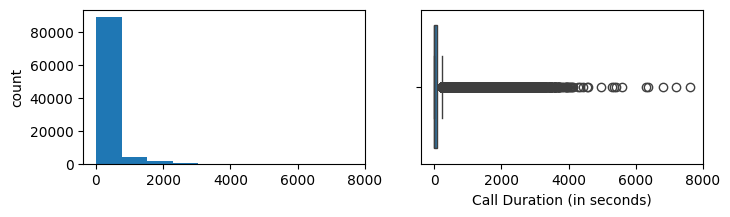

------------------------------------------------------------ Scheduled in CRM ------------------------------------------------------------


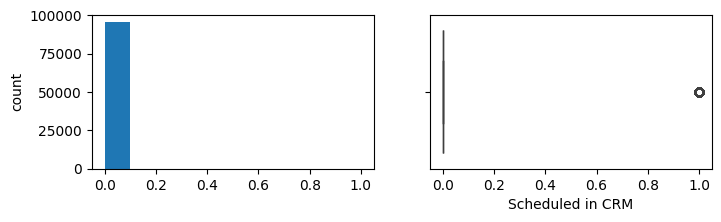

------------------------------------------------------------ Flag_Call Duration (in seconds) ------------------------------------------------------------


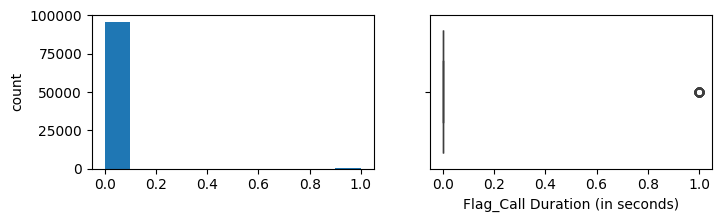

------------------------------------------------------------ Flag_Scheduled in CRM ------------------------------------------------------------


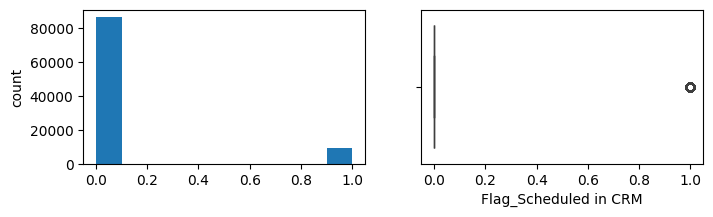

In [107]:
for column in data_calls.select_dtypes([int, float]).columns:
    print("--" * 30, column, "--" * 30)
    plt.figure(figsize = (8, 2))
    plt.subplot(1, 2, 1)
    data_calls[column].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_calls[column])
    plt.show()

In fact, this table contains only one numeric column — Call Duration (in seconds). The rest have values of 0 or 1, so their plots resemble those of categorical variables.

### data_contacts

In [108]:
data_contacts.describe()

,Created Time,Modified Time
count,18538,18538
mean,2024-01-24 15:39:59.889955840,2024-02-15 09:36:26.061063680
min,2023-06-27 11:28:00,2023-07-06 10:54:00
25%,2023-11-15 18:06:15,2023-12-09 15:04:00
50%,2024-02-01 18:45:00,2024-02-29 00:47:30
75%,2024-04-12 16:49:15,2024-04-26 22:40:45
max,2024-06-21 15:30:00,2024-06-21 15:32:00


Здесь нет числовых переменных, только datetime64

### data_deals

In [109]:
data_deals.describe()

,Closing Date,Created Time,Course duration,Months of study,SLA_seconds,SLA_minutes,SLA_hours,InAmountPaid cleaned,OfTotAmount cleaned
count,13027,19610,19610.000000,19610.000000,1.481400e+04,14814.000000,14814.000000,19610.000000,19610.000000
mean,2024-01-28 09:36:59.622322688,2024-01-27 22:46:40.038755584,1.814635,0.229679,1.120312e+05,1867.186815,31.119824,191.022438,1485.628149
min,2023-07-03 00:00:00,2022-10-11 00:00:00,0.000000,0.000000,3.000000e+00,0.050000,0.000000,0.000000,0.000000
25%,2023-11-10 12:00:00,2023-11-18 14:50:45,0.000000,0.000000,4.392000e+03,73.200000,1.220000,0.000000,0.000000
50%,2024-02-08 00:00:00,2024-02-06 07:29:30,0.000000,0.000000,1.974900e+04,329.150000,5.490000,0.000000,0.000000
75%,2024-04-18 00:00:00,2024-04-14 11:57:30,0.000000,0.000000,5.581375e+04,930.229167,15.500000,0.000000,0.000000
max,2024-12-11 00:00:00,2024-06-21 15:30:00,11.000000,11.000000,2.690846e+07,448474.400000,7474.570000,11000.000000,11500.000000
std,NaN,NaN,3.976262,1.248785,7.302550e+05,12170.915933,202.848589,709.124255,3586.417015


---------------------------------------- Course duration ----------------------------------------


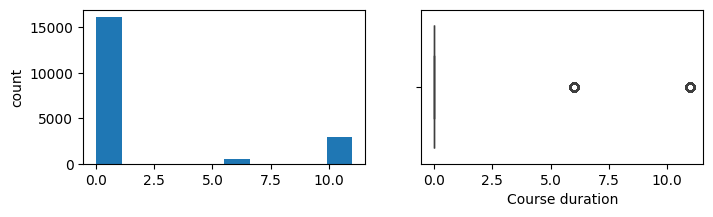

---------------------------------------- Months of study ----------------------------------------


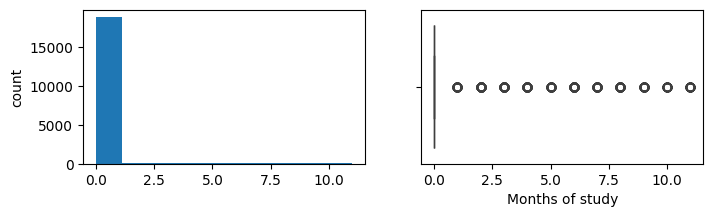

---------------------------------------- SLA_seconds ----------------------------------------


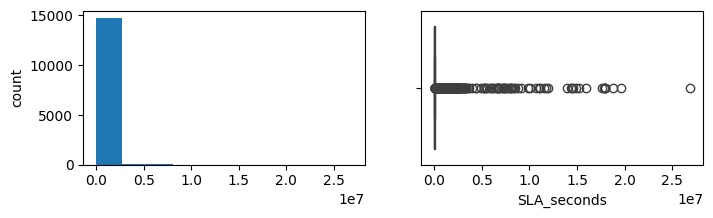

---------------------------------------- SLA_minutes ----------------------------------------


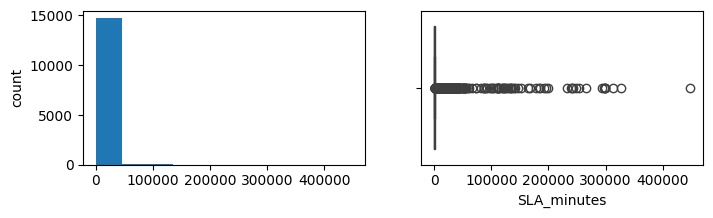

---------------------------------------- SLA_hours ----------------------------------------


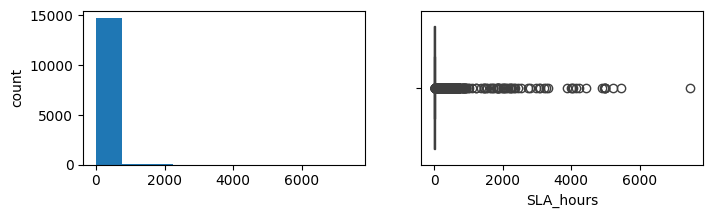

---------------------------------------- InAmountPaid cleaned ----------------------------------------


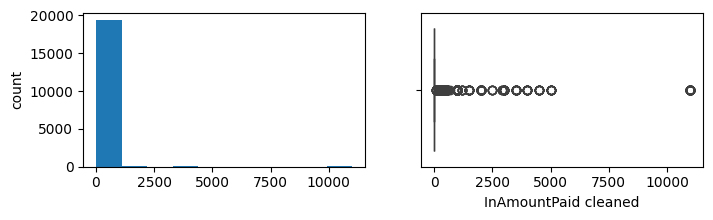

---------------------------------------- OfTotAmount cleaned ----------------------------------------


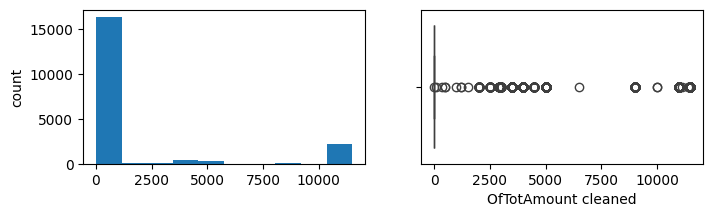

In [110]:
for column in data_deals.select_dtypes([int, float]).columns:
    print("--" * 20, column, "--" * 20)
    plt.figure(figsize = (8, 2))
    plt.subplot(1, 2, 1)
    data_deals[column].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_deals[column])
    plt.show()

Only the SLA variables (all variants), InAmountPaid cleaned, and OfTotAmount cleaned are fully numeric. The rest appear to behave like categorical variables.

### data_spend

In [111]:
data_spend.describe()

,Date,Impressions,Spend,Clicks
count,14887,14887.000000,14887.000000,14887.000000
mean,2024-01-09 17:16:55.893061376,3427.332774,9.983453,31.062806
min,2023-07-03 00:00:00,0.000000,0.000000,0.000000
25%,2023-10-05 00:00:00,34.000000,0.300000,0.000000
50%,2024-01-22 00:00:00,286.000000,2.330000,4.000000
75%,2024-04-11 00:00:00,1060.000000,8.885000,17.000000
max,2024-06-21 00:00:00,431445.000000,774.000000,2415.000000
std,NaN,13395.468506,31.159348,98.414714


---------------------------------------- Impressions ----------------------------------------


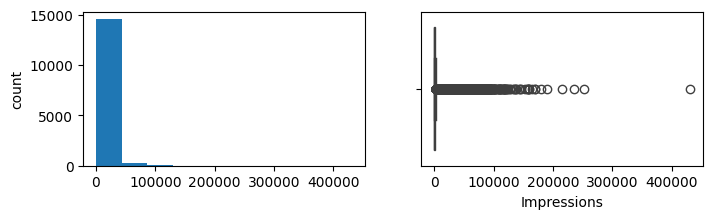

---------------------------------------- Spend ----------------------------------------


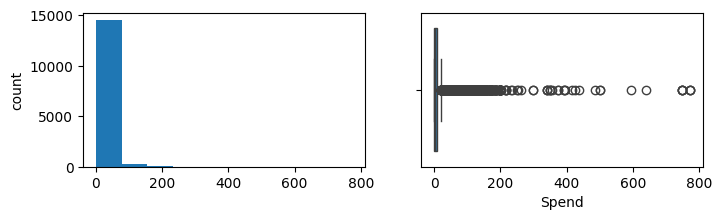

---------------------------------------- Clicks ----------------------------------------


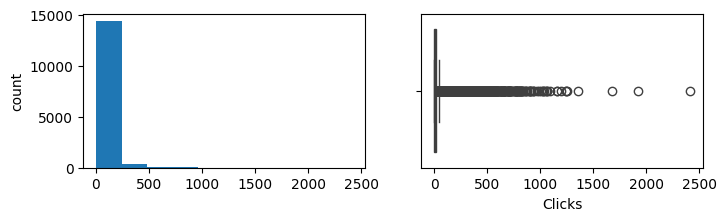

In [112]:
for column in data_spend.select_dtypes([int, float]).columns:
    print("--" * 20, column, "--" * 20)
    plt.figure(figsize = (8, 2))
    plt.subplot(1, 2, 1)
    data_spend[column].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data_spend[column])
    plt.show()

In [113]:
data_spend[data_spend['Impressions'] == data_spend['Impressions'].max()]

,Date,Source,Campaign,Impressions,Spend,Clicks,AdGroup,Ad
2924,2023-09-03,Google Ads,performancemax_eng_DE,431445,236.1,1920,Unknown,Unknown


There is an outlier in the "Impressions" field — 431,445 ad views. However, the cost of this ad is not the highest (maximum spend is 774, while this one is only 236.1). The number of clicks is high. The source of this ad is Google Ads — it’s worth verifying whether such a cost for this volume of impressions is acceptable for this platform.

### Time series compatibility across all tables.

All tables contain temporal features. A compatibility check is required — they must all cover the same time period.

In [114]:
print(data_calls['Call Start Time'].min(), data_calls['Call Start Time'].max())
print(data_contacts['Created Time'].min(), data_contacts['Created Time'].max())
print(data_deals['Created Time'].min(), data_deals['Created Time'].max())
print(data_spend['Date'].min(), data_spend['Date'].max())

2023-06-30 08:43:00 2024-06-21 15:31:00
2023-06-27 11:28:00 2024-06-21 15:30:00
2022-10-11 00:00:00 2024-06-21 15:30:00
2023-07-03 00:00:00 2024-06-21 00:00:00


In all four tables, the latest date matches, but the initial dates differ. To ensure time series compatibility, I’ll select the latest of the initial dates and trim the data in the other three tables accordingly.

In [115]:
start_max_date = max(data_calls['Call Start Time'].min(), data_contacts['Created Time'].min(), data_deals['Created Time'].min(), data_spend['Date'].min())
start_max_date

Timestamp('2023-07-03 00:00:00')

In [116]:
data_calls = data_calls[data_calls['Call Start Time'] >= start_max_date]
data_contacts = data_contacts[data_contacts['Created Time'] >= start_max_date]
data_deals = data_deals[data_deals['Created Time'] >= start_max_date]

In [117]:
# print(data_calls['Call Start Time'].min(), data_calls['Call Start Time'].max())
# print(data_contacts['Created Time'].min(), data_contacts['Created Time'].max())
# print(data_deals['Created Time'].min(), data_deals['Created Time'].max())
# print(data_spend['Date'].min(), data_spend['Date'].max())

## *Analyze categorical fields such as quality, stage, source, and product.*


### data_calls

In [118]:
data_calls.describe(include=['object'])

,Id,Call Owner Name,CONTACTID,Call Type,Call Status,Outgoing Call Status
count,95785,95785,91858,95785,95785,86793
unique,95785,33,15214,3,11,4
top,5805028000056893631,Yara Edwards,5805028000003329100,Outbound,Attended Dialled,Completed
freq,1,9054,94,86793,70621,86710


Outbound  / Attended Dialled  / Completed

Considering that the table contains nearly 96,000 records, I don’t see anything unusual. There are many outgoing calls and dialed numbers — the managers are actively working. Almost all entries are marked as completed, which is also a good sign, indicating that managers are fully processing requests.





### data_contacts

In [119]:
data_contacts.describe(include=['object', 'category'])

,Id,Contact Owner Name
count,18536,18536
unique,18536,27
top,5805028000056907001,Charlie Davis
freq,1,2018


Charlie Davis has a very high number of repeated entries. Let’s compare with other managers to determine whether it’s excessive or typical.

In [120]:
aggregated_data = data_contacts.groupby('Contact Owner Name').agg({'Id': 'count','Created Time': 'min','Modified Time': 'max'})
sorted_data = aggregated_data.sort_values(by='Id', ascending=False)

print(sorted_data.head())

                      Id        Created Time       Modified Time
Contact Owner Name                                              
Charlie Davis       2018 2023-07-03 11:31:00 2024-06-21 14:07:00
Ulysses Adams       1816 2023-07-10 08:10:00 2024-06-21 15:24:00
Julia Nelson        1769 2023-07-04 11:46:00 2024-06-20 22:12:00
Paula Underwood     1487 2023-07-23 11:57:00 2024-06-21 15:03:00
Quincy Vincent      1416 2023-07-05 18:05:00 2024-06-21 13:12:00


Charlie Davis has been working for a long time, and his performance is higher than others — but not by much. The second-ranking manager is only 200 records behind. Looking at the difference between managers, this might be normal. It’s important to check how many working days each has had to draw a final conclusion.

### data_deals

In [121]:
data_deals.describe(include=['object', 'category'])

,Id,Deal Owner Name,Quality,Stage,Lost Reason,Page,Campaign,Content,Term,Source,Payment Type,Product,Education Type,Contact Name,City,Level of Deutsch
count,19609,19609,19609,19609,14235,19609,19609,19609,19609,19609,474,3490,3215,19609,3095,1565
unique,19609,28,6,13,20,31,151,180,215,12,3,3,2,16867,869,213
top,5805028000000922001,Charlie Davis,E - Non Qualified,Lost,Doesn't Answer,/eng,Unknown,Unknown,Unknown,Facebook Ads,Recurring Payments,Digital Marketing,Morning,5805028000003014152,-,B1
freq,1,2910,6099,13886,4113,5680,4156,5973,7670,4726,337,1933,2819,24,421,269


There are many categorical variables here, and many of them contain the value "Unknown". The importance of each category should be investigated during domain-specific analysis. If we filter out seemingly "uninformative" values for each feature at this stage, it may lead to excessive data loss. Therefore, filtering will only be done during targeted analysis.

### data_spend

In [122]:
data_spend.describe(include=['object', 'category'])

,Source,Campaign,AdGroup,Ad
count,14887,14887,14887,14887
unique,13,51,21,166
top,Facebook Ads,12.07.2023wide_DE,wide,Unknown
freq,8749,1837,4847,2086


All four fields can be considered categorical — the number of unique values is significantly smaller than the total number of records.

# ***Saving the results***

In [123]:
df = {'calls_clear': data_calls, 'contacts_clear': data_contacts, 'deals_clear': data_deals, 'spend_clear': data_spend}

with open('data_1.pkl', 'wb') as f:
    pickle.dump(df, f)

In [124]:
with open('data_1.pkl', 'rb') as f:
    data_1 = pickle.load(f)

In [125]:
data_1.keys()

dict_keys(['calls_clear', 'contacts_clear', 'deals_clear', 'spend_clear'])

In [126]:
calls_clear, contacts_clear, deals_clear, spend_clear  = data_1.values()